# Demo workflows

In [1]:
import xarray as xr
import ocean_data_gateway as odg
import cf_xarray
import pandas as pd
import extract_model as em
import ocean_model_skill_assessor as omsa
import numpy as np

Things to update:
Input file examples
script to import input file
finish CLI
Jesse
get all the docs to build including omsa

Show Jesse what libraries need to be included, example

known limitations in presentation

Push notebook
Show simpler dictionaries
Switch to file



## Definitions

In [10]:
# regex notes:
# $ at the end means it will only find exact matches
# (?!.*?_qc) at the end means it will not match with the string if "_qc" is anywhere in the string
# (?!.*(skin|ground)) at the end means to ignore match if it contains "skin" or "ground"
# (?i) at the beginning means to ignore case
criteria = {
    # ssh excludes 'sea_surface_height_amplitude_due_to_geocentric_ocean_tide_geoid_mllw' because
    # it is used for NOAA/CO-OPS tidal predictions, not data.
    "ssh": {
        "standard_name": "sea_surface_height$|sea_surface_elevation|sea_surface_height_above_sea_level$",
        "name": "(?i)sea_surface_elevation(?!.*?_qc)|(?i)sea_surface_height_above_sea_level_geoid_mllw$|(?i)zeta$|(?i)Sea Surface Height(?!.*?_qc)|(?i)Water Surface above Datum(?!.*?_qc)"
    },
    "temp": {
        # standard_names are used multiple times in datasets sometimes so don't distinguish variables.
#         "standard_name": "sea_water_temperature",
        "name": "(?i)temp$|(?i)temperature$|(?i)tem$|(?i)s.sea_water_temperature$|(?i)temperature(?!.*(skin|ground|air|_qc))"
    },
    "salt": {
        # standard_names are used multiple times in datasets sometimes so don't distinguish variables.
        "standard_name": "sea_water_salinity$|sea_water_practical_salinity$",
        "name": "(?i)salinity(?!.*(soil|_qc))|(?i)sea_water_salinity$|(?i)sea_water_practical_salinity$|(?i)salinity$|(?i)salt$|(?i)sal$|(?i)s.sea_water_practical_salinity$",
    },
    "u": {
        "standard_name": "eastward_sea_water_velocity$|sea_water_x_velocity|surface_eastward_sea_water_velocity",
        "name": "(?i)eastward_sea_water_velocity(?!.*?_qc)|(?i)sea_water_x_velocity(?!.*?_qc)|(?i)uo(?!.*?_qc)",
    },
    "v": {
        "standard_name": "northward_sea_water_velocity$|sea_water_y_velocity|surface_northward_sea_water_velocity",
         "name": "(?i)northward_sea_water_velocity(?!.*?_qc)|(?i)sea_water_y_velocity(?!.*?_qc)|(?i)vo(?!.*?_qc)",
    },
    "wind_speed": {
        "standard_name": "wind_speed$",
    },
}

var_def = {
    "temp": {
        "units": "degree_Celsius",
        "fail_span": [-100, 100],
        "suspect_span": [-10, 40],
    },
    "salt": {"units": "psu", "fail_span": [-10, 60], "suspect_span": [-1, 45]},
    "u": {"units": "m/s", "fail_span": [-10, 10], "suspect_span": [-5, 5]},
    "v": {"units": "m/s", "fail_span": [-10, 10], "suspect_span": [-5, 5]},
    "ssh": {"units": "m", "fail_span": [-10, 10], "suspect_span": [-3, 3]},
}


## Local workflow, Python library

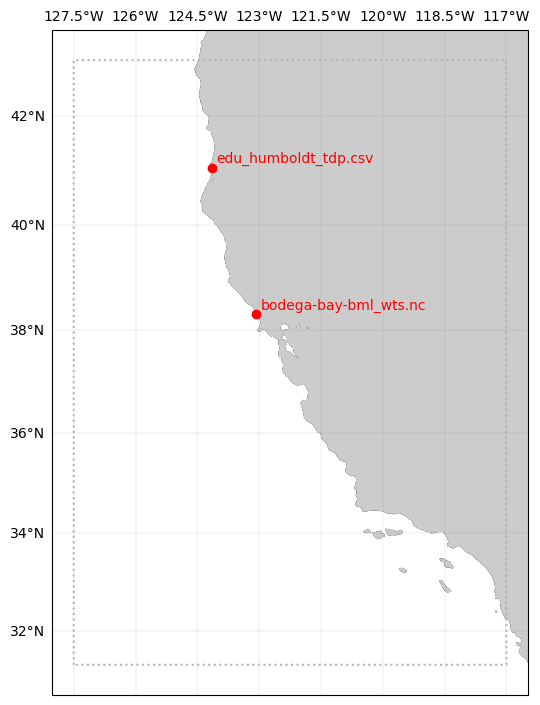

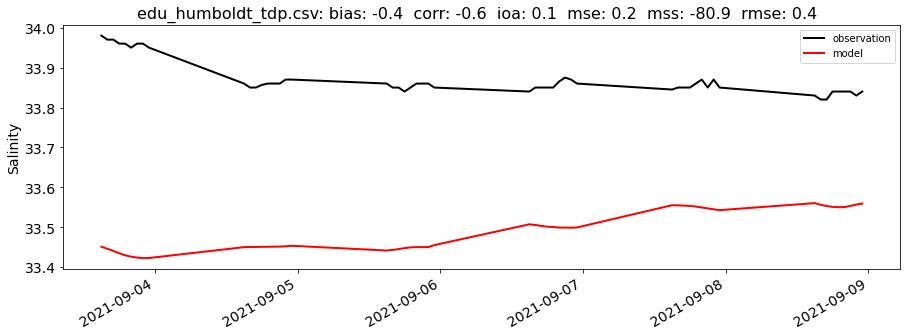

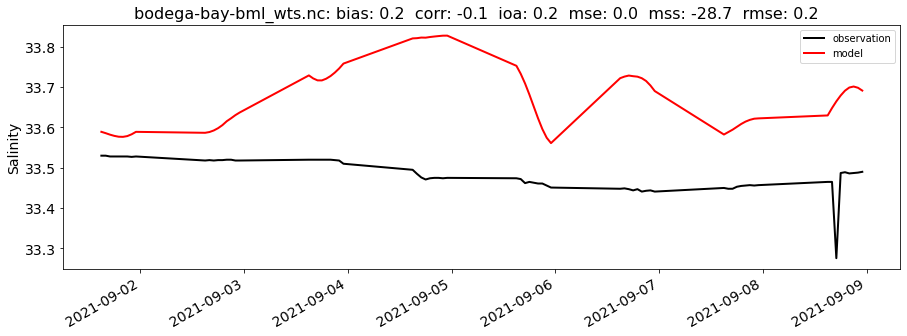

In [3]:
# criteria_url = 'https://gist.githubusercontent.com/kthyng/c3cc27de6b4449e1776ce79215d5e732/raw/af448937e4896535e36ef6522df8460e8f928cd6/my_custom_criteria.py'

omsa.set_criteria(criteria)

model_url = 'https://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc'
filenames = [
             '../data/edu_humboldt_tdp.csv',
            '../data/bodega-bay-bml_wts.nc',
            ]

skip_units = True

search = omsa.run(
                  loc_model=model_url,
                  approach='region',
                  criteria=criteria,
                  var_def=var_def,
                  skip_units=skip_units,
                  xarray_kwargs={'chunks': {'time': 1, 'depth': 1}},
                  time_range=['2021-9-1','2021-9-8'], 
                  variables=['salt'],
                  readers=[odg.local],
                  local={'filenames': filenames}
)

## Nonlocal workflow, python library

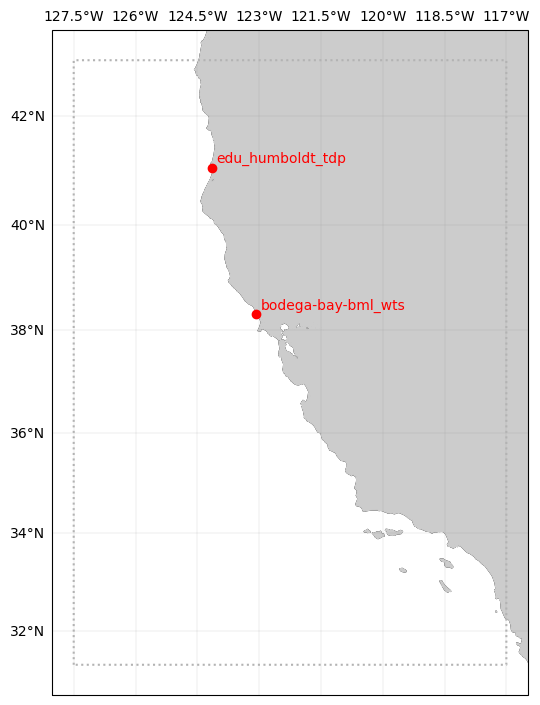

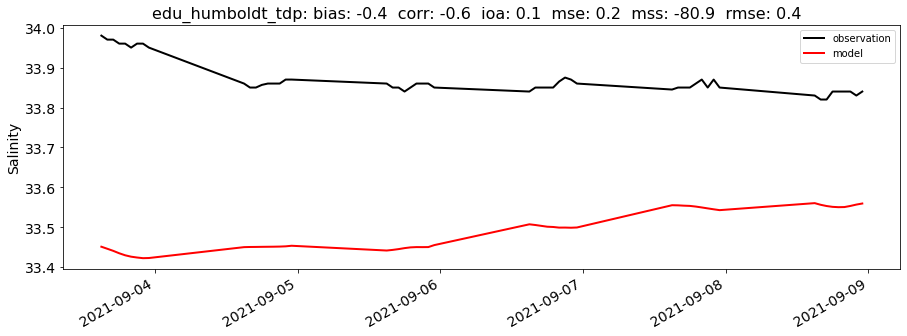

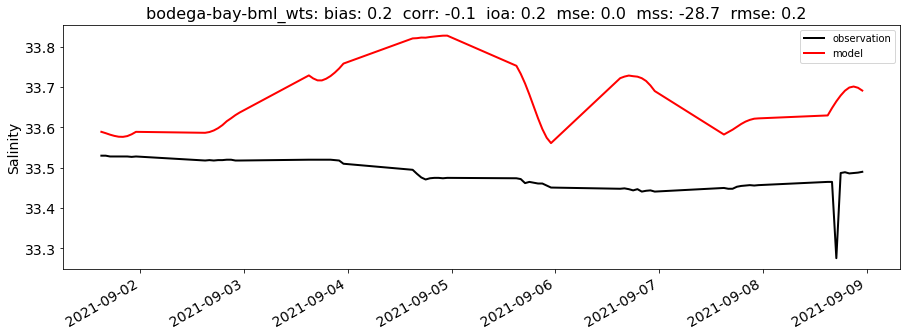

In [3]:
# criteria_url = 'https://gist.githubusercontent.com/kthyng/c3cc27de6b4449e1776ce79215d5e732/raw/af448937e4896535e36ef6522df8460e8f928cd6/my_custom_criteria.py'

omsa.set_criteria(criteria)

model_url = 'https://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc'

dataset_ids = ['edu_humboldt_tdp','bodega-bay-bml_wts']

search = omsa.run(
                  loc_model=model_url,
                  approach='stations',
                  criteria=criteria,
                  var_def=var_def,
                  xarray_kwargs={'chunks': {'time': 1, 'depth': 1}},
                  time_range=['2021-9-1','2021-9-8'], 
                  variables=['salt'],
                  readers=[odg.erddap],
                  erddap={
                      'known_server': 'ioos'
                  },
                  stations = dataset_ids
)

## Local workflow, CLI

In [4]:

model_url = 'https://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc'
filenames = [
             '../data/edu_humboldt_tdp.csv',
            '../data/bodega-bay-bml_wts.nc',
            ]

time_range = ['2021-9-1','2021-9-8']
xarray_kwargs={'chunks': {'time': 1, 'depth': 1}}
variables=['salt']
readers=['local']
local={'filenames': filenames}

# search = omsa.run(
#                   loc_model=model_url,
#                   approach='region',
#                   criteria=criteria,
#                   var_def=var_def,
#                   skip_units=skip_units,
#                   xarray_kwargs={'chunks': {'time': 1, 'depth': 1}},
#                   time_range=['2021-9-1','2021-9-8'], 
#                   variables=['salt'],
#                   readers=[odg.local],
#                   local={'filenames': filenames}
# )

In [16]:
!python ../ocean_model_skill_assessor/CLI.py $model_url region \
                                            --criteria="$criteria" \
                                            --var_def="$var_def" \
                                            --skip_units \
                                            --xarray_kwargs="$xarray_kwargs" \
                                            --variables="$variables" \
                                            --readers="$readers" \
                                            --time_range="$time_range" \
                                            --local="$local"

No dataset_ids found. Try a different search.


## Nonlocal workflow, CLI